**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

In [4]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents
from stardist import fill_label_holes, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

This notebook demonstrates how the training data for *StarDist* should look like and whether the annotated objects can be appropriately described by star-convex polyhedra. 

<div class="alert alert-block alert-info">
The training data that needs to be provided for StarDist consists of corresponding pairs of raw images and pixelwise annotated ground truth images (masks), where every pixel has a unique integer value indicating the object id (or 0 for background). 
</div>

For this demo we will download the file file `demo3D.zip` that contains synthetic train and test images with associated ground truth labels.

In [5]:
# Define the input and output directories
image_dir = r"C:\Users\INTEL9-12900K\Documents\Python\stardist\examples\3D\data\train\images"
mask_dir = r"C:\Users\INTEL9-12900K\Documents\Python\stardist\examples\3D\data\train\masks"

In [6]:
import os
import numpy as np
from tifffile import imread, imwrite

# Define the input and output directories
image_dir = r"C:\Users\INTEL9-12900K\Documents\Python\stardist\examples\3D\data\train\images"
mask_dir = r"C:\Users\INTEL9-12900K\Documents\Python\stardist\examples\3D\data\train\masks"

# Create new directories for the output files
output_image_dir = os.path.join(image_dir, 'chunked_images')
output_mask_dir = os.path.join(mask_dir, 'chunked_masks')
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Define the chunk size
chunk_size = np.array([64, 128, 128])
overlap_fraction = 0.25

# Overlap size in each dimension
overlap_size = chunk_size * overlap_fraction
stride = chunk_size - overlap_size.astype(int)

# Iterate over all TIF files in the images directory
for filename in os.listdir(image_dir):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        # Read the image and its corresponding mask
        image = imread(os.path.join(image_dir, filename))
        mask = imread(os.path.join(mask_dir, filename))

        if image.shape != mask.shape:
            print(f"Warning: Image and mask dimensions do not match for {filename}.")
            continue
            
        # Check if image dimensions are bigger than chunk_size
        if all(dim >= size for dim, size in zip(image.shape, chunk_size)):
            image_chunks = []
            mask_chunks = []
            # Start positions for chunks
            for z in range(0, image.shape[0] - chunk_size[0] + 1, stride[0]):
                for y in range(0, image.shape[1] - chunk_size[1] + 1, stride[1]):
                    for x in range(0, image.shape[2] - chunk_size[2] + 1, stride[2]):
                        # Append chunks to the lists
                        image_chunks.append(image[z:z + chunk_size[0], y:y + chunk_size[1], x:x + chunk_size[2]])
                        mask_chunks.append(mask[z:z + chunk_size[0], y:y + chunk_size[1], x:x + chunk_size[2]])

            # Write the chunks to new TIF files only if the mask has values greater than 0 in at least half the slices
            base_filename = os.path.splitext(filename)[0]
            for i, (image_chunk, mask_chunk) in enumerate(zip(image_chunks, mask_chunks)):
                # Check if values in at least half the slices of the mask_chunk are greater than 0
                if np.sum(np.any(mask_chunk > 0, axis=(1, 2))) >= chunk_size[0] / 2:
                    imwrite(os.path.join(output_image_dir, f"{base_filename}_{i}.tif"), image_chunk)
                    imwrite(os.path.join(output_mask_dir, f"{base_filename}_{i}.tif"), mask_chunk)
        else:
            print(f"Skipping {filename} as its dimensions are smaller than the chunk size.")

In [18]:
X = sorted(glob('data/train/images/chunked_images/*.tif'))
Y = sorted(glob('data/train/masks/chunked_masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

Load only a small subset.

In [19]:
X, Y = X[:10], Y[:10]

In [20]:
X = list(map(imread,X))
Y = list(map(imread,Y))

In [21]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.1428571428571428, 1.0, 1.0666666666666667)


# Example image

In [22]:
i = 0
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (3,4)
# assumed axes ordering of img and lbl is: ZYX(C)

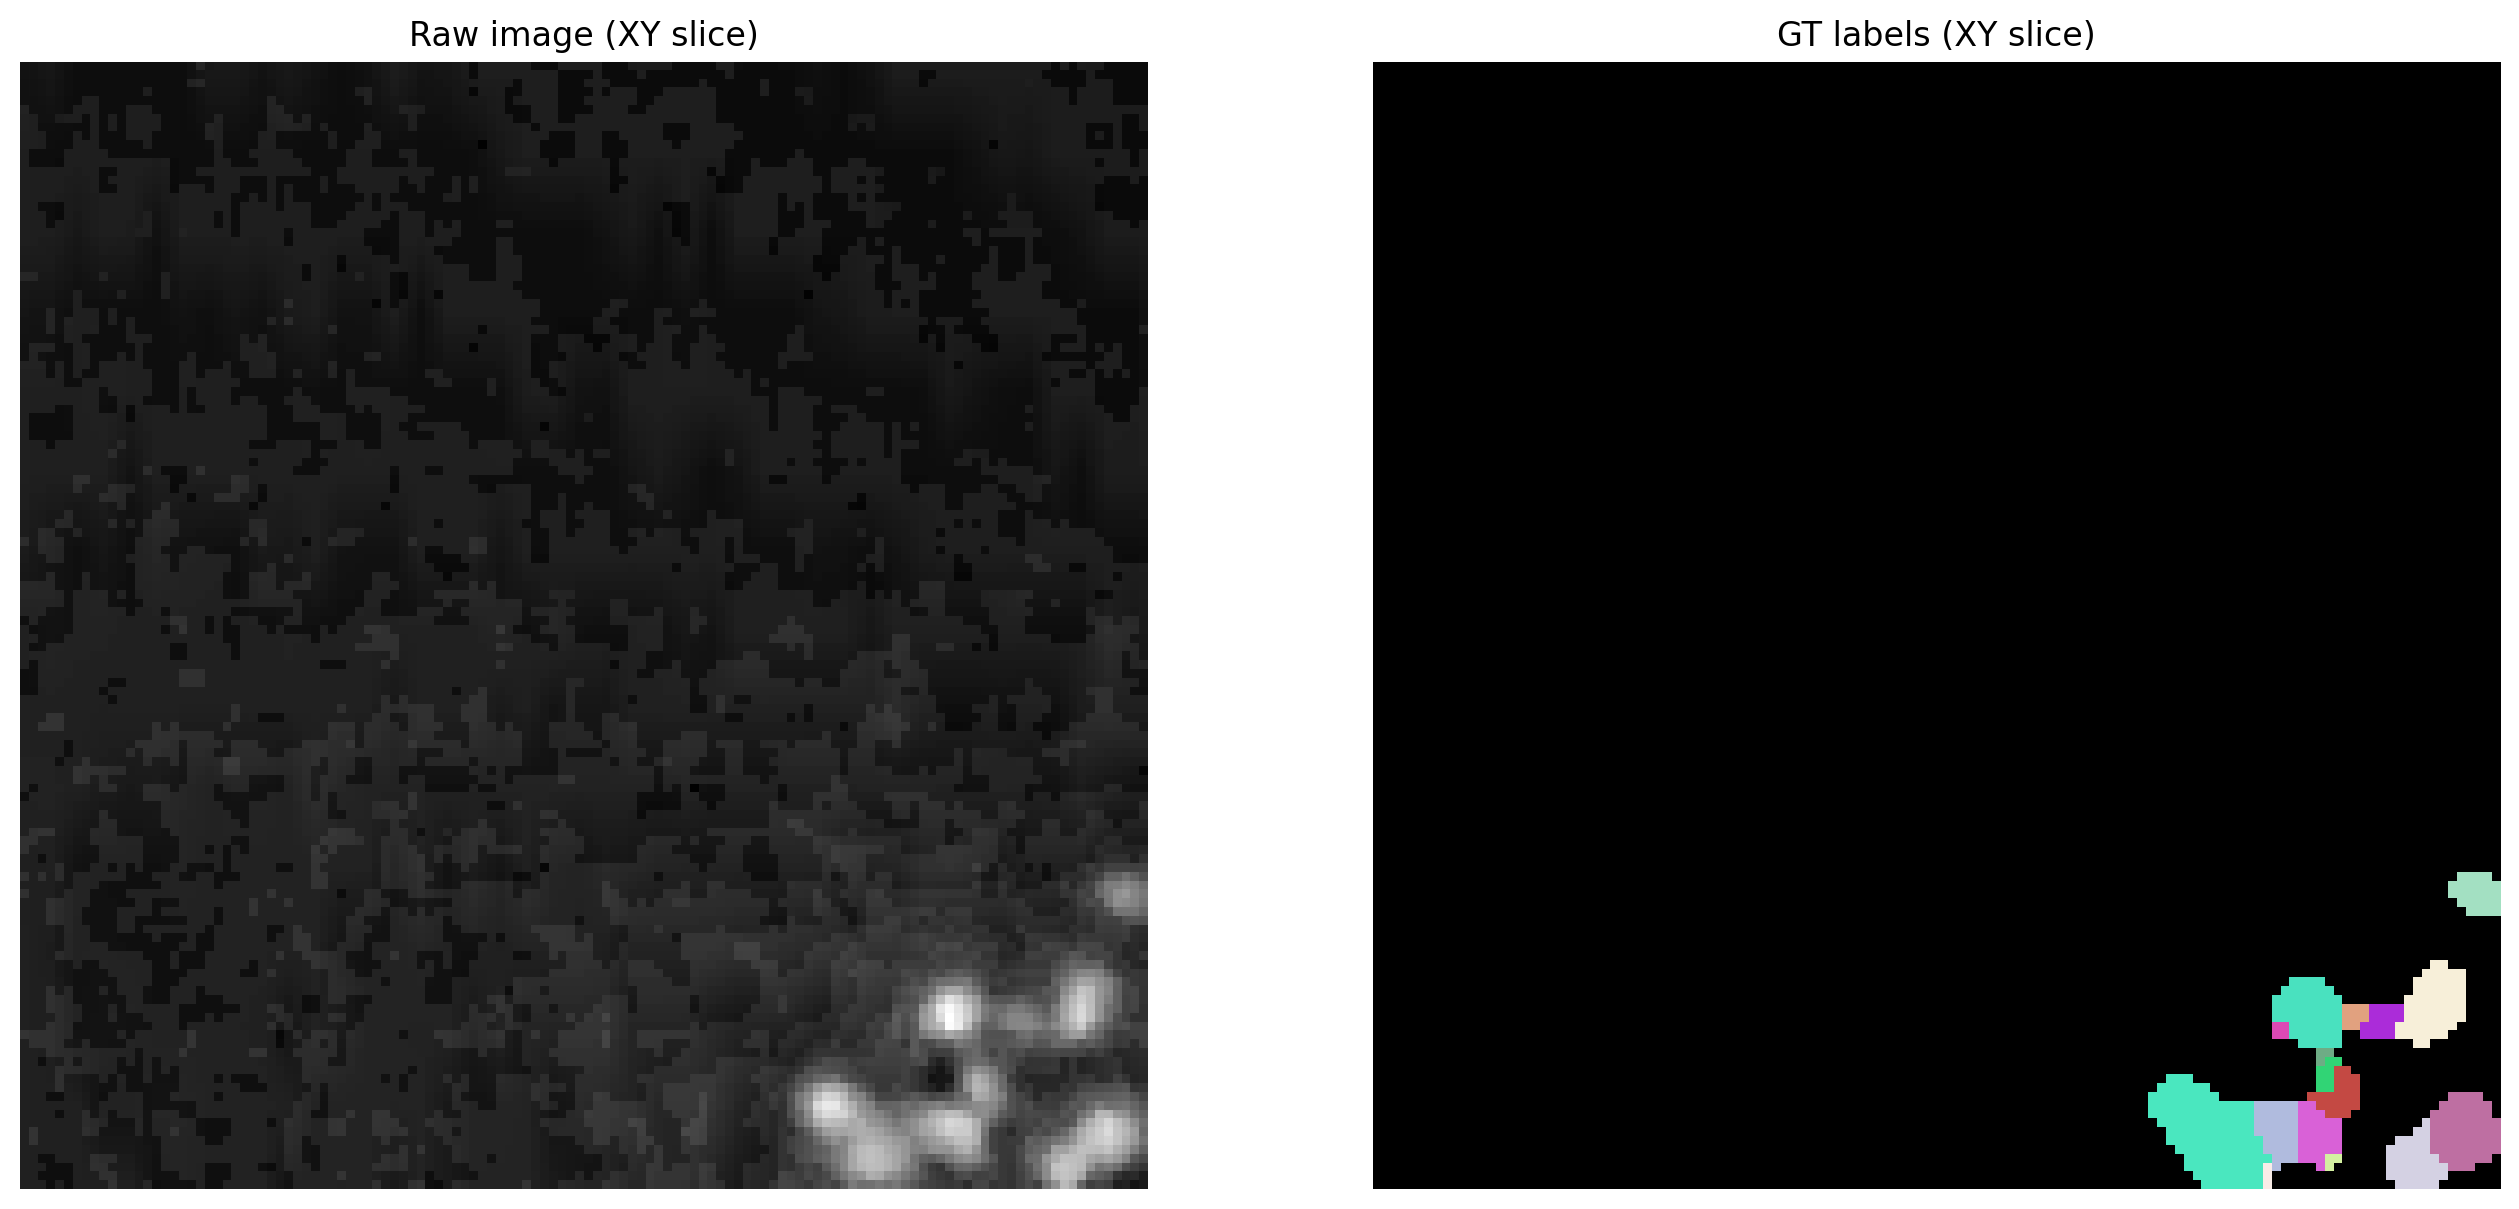

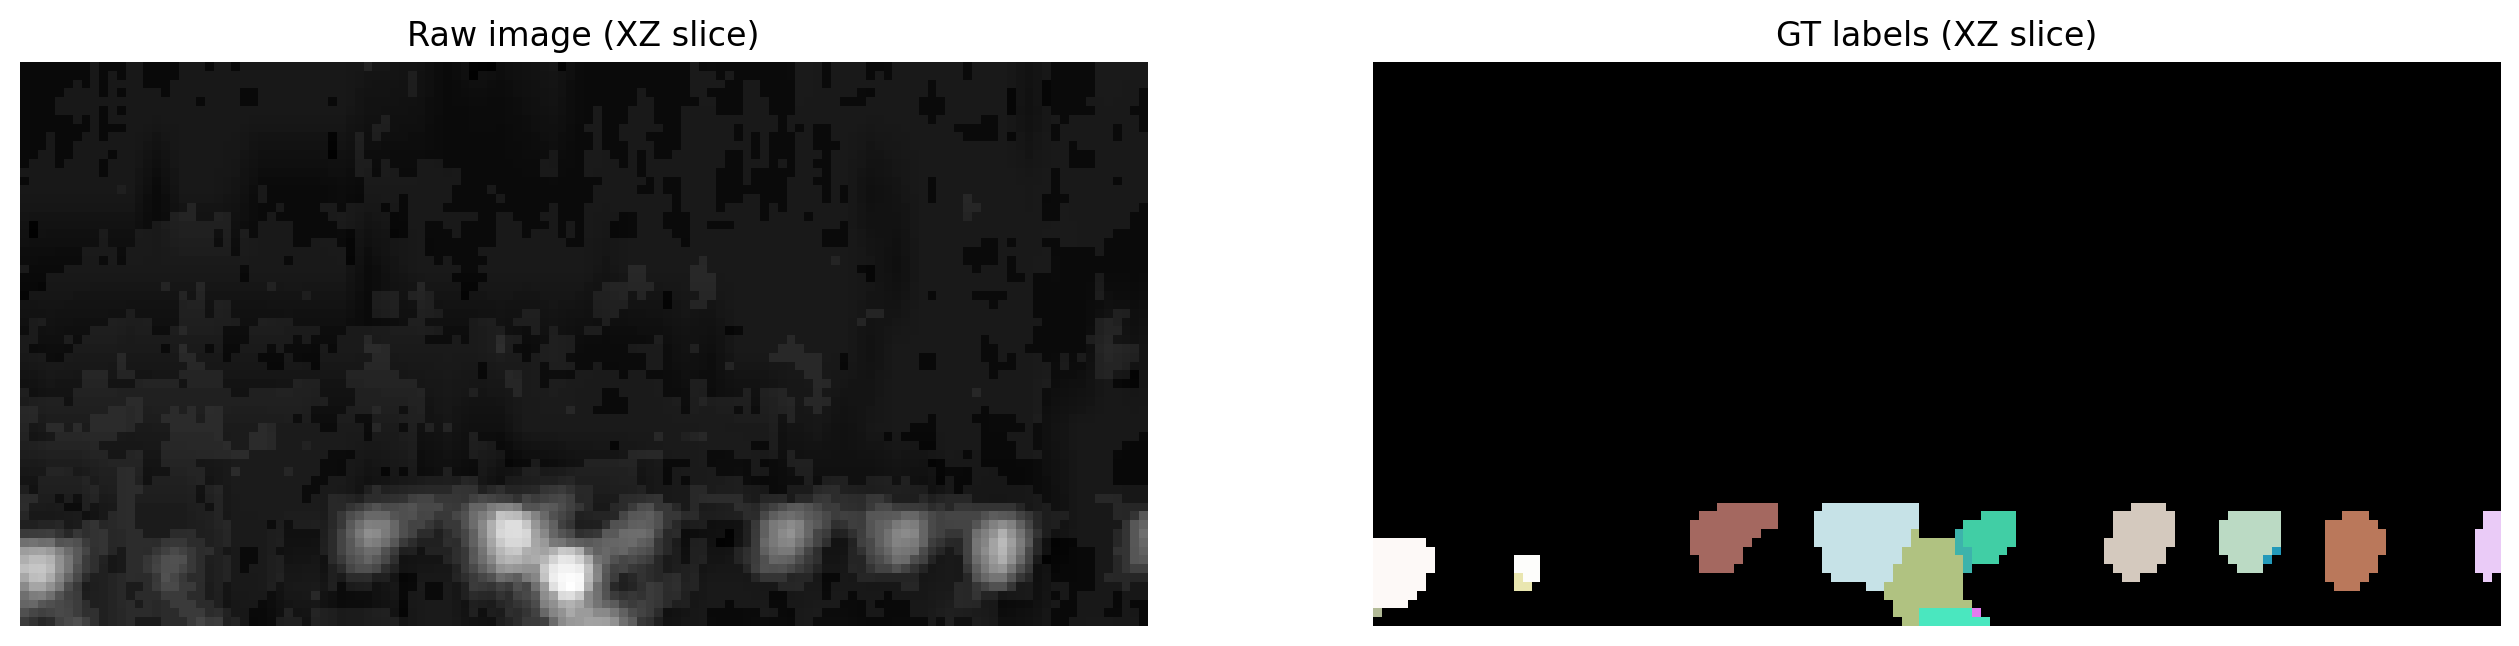

In [23]:
plt.figure(figsize=(16,10))
z = img.shape[0] // 2
y = img.shape[1] // 2
plt.subplot(121); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw image (XY slice)')
plt.subplot(122); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XY slice)')
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img[:,y],cmap='gray');   plt.axis('off'); plt.title('Raw image (XZ slice)')
plt.subplot(122); plt.imshow(lbl[:,y],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XZ slice)')
None;

# Fitting ground-truth labels with star-convex polyhedra

In [24]:
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in Y]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores

In [25]:
n_rays = [8, 16, 32, 64, 96, 128]
scores_iso   = reconstruction_scores(n_rays, anisotropy=None)
scores_aniso = reconstruction_scores(n_rays, anisotropy=anisotropy)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:36<00:00, 26.01s/it]


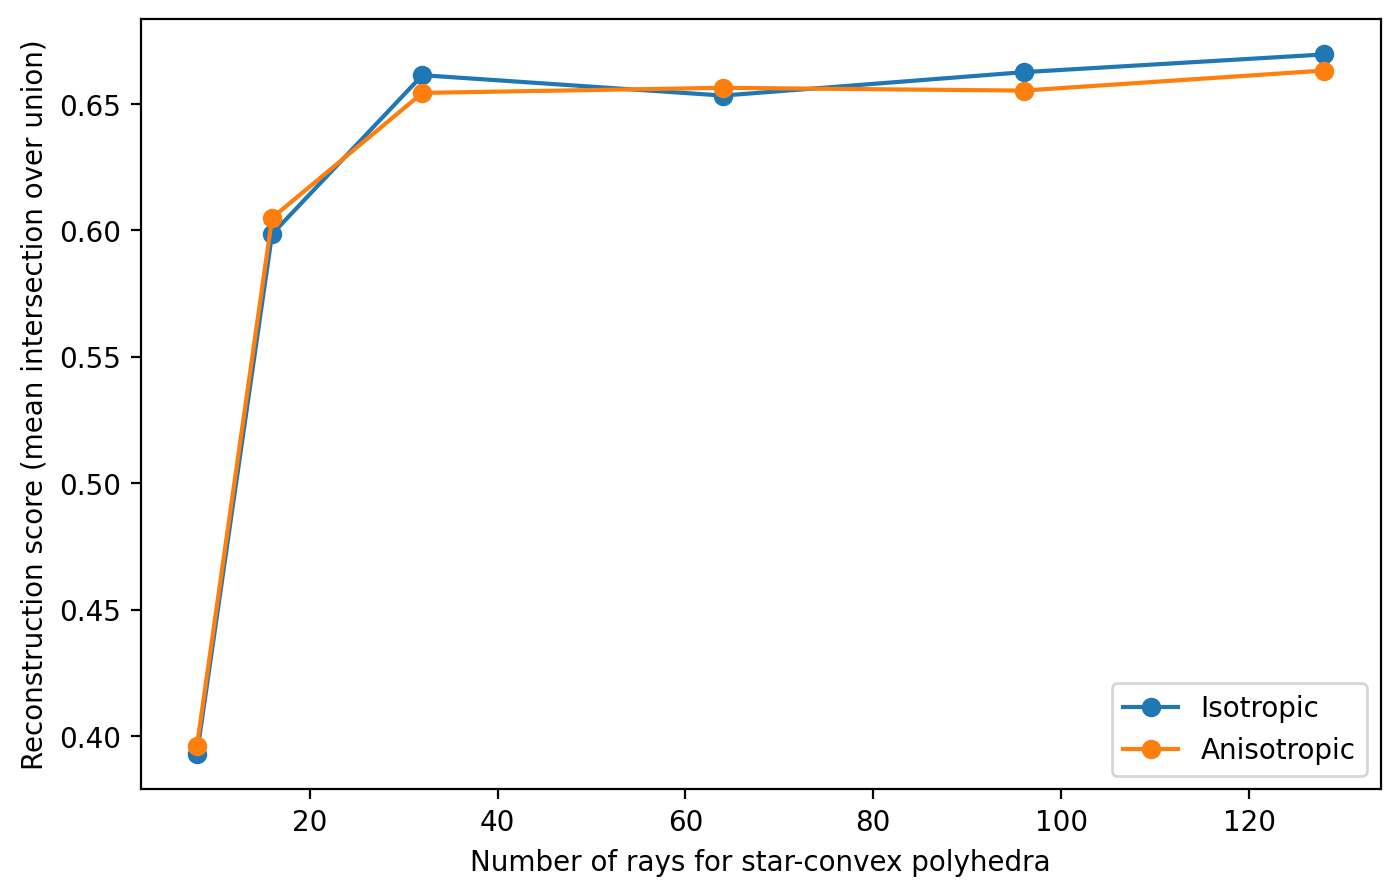

In [26]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores_iso,   'o-', label='Isotropic')
plt.plot(n_rays, scores_aniso, 'o-', label='Anisotropic')
plt.xlabel('Number of rays for star-convex polyhedra')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.legend()
None;

# Example image reconstructed with various number of rays

## Without taking anisotropy into account

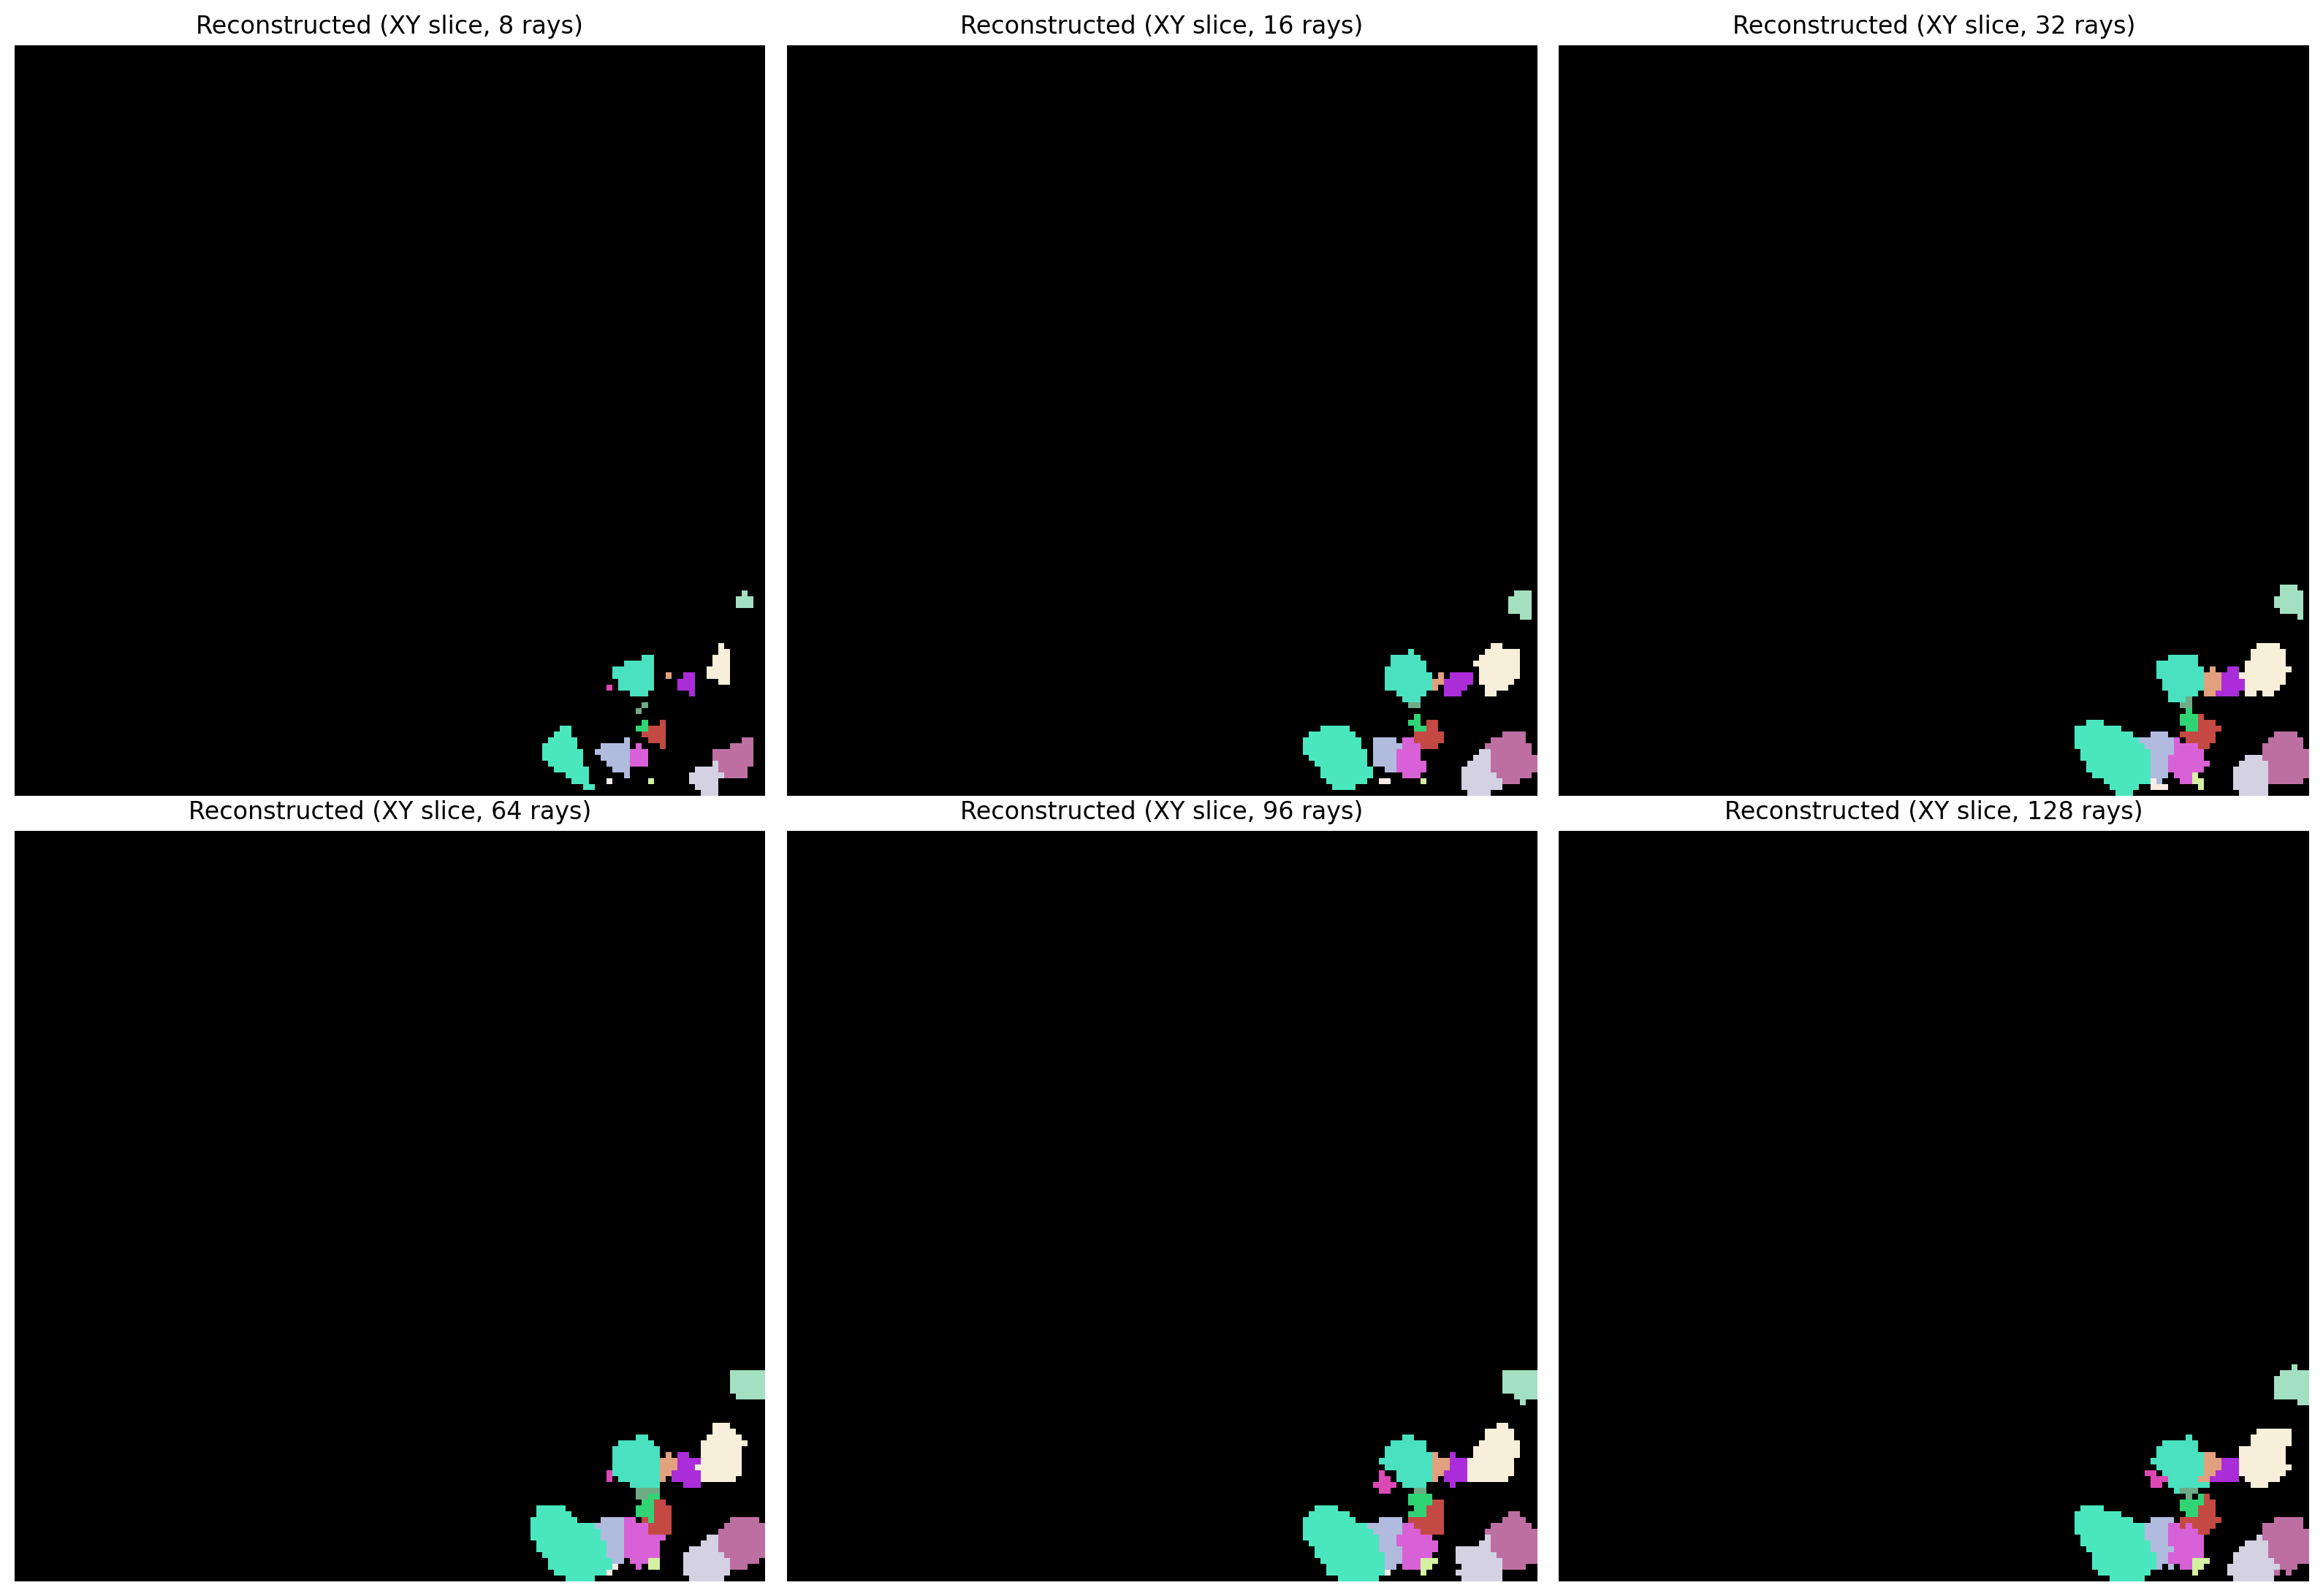

In [27]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=None)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();

## Taking anisotropy into account

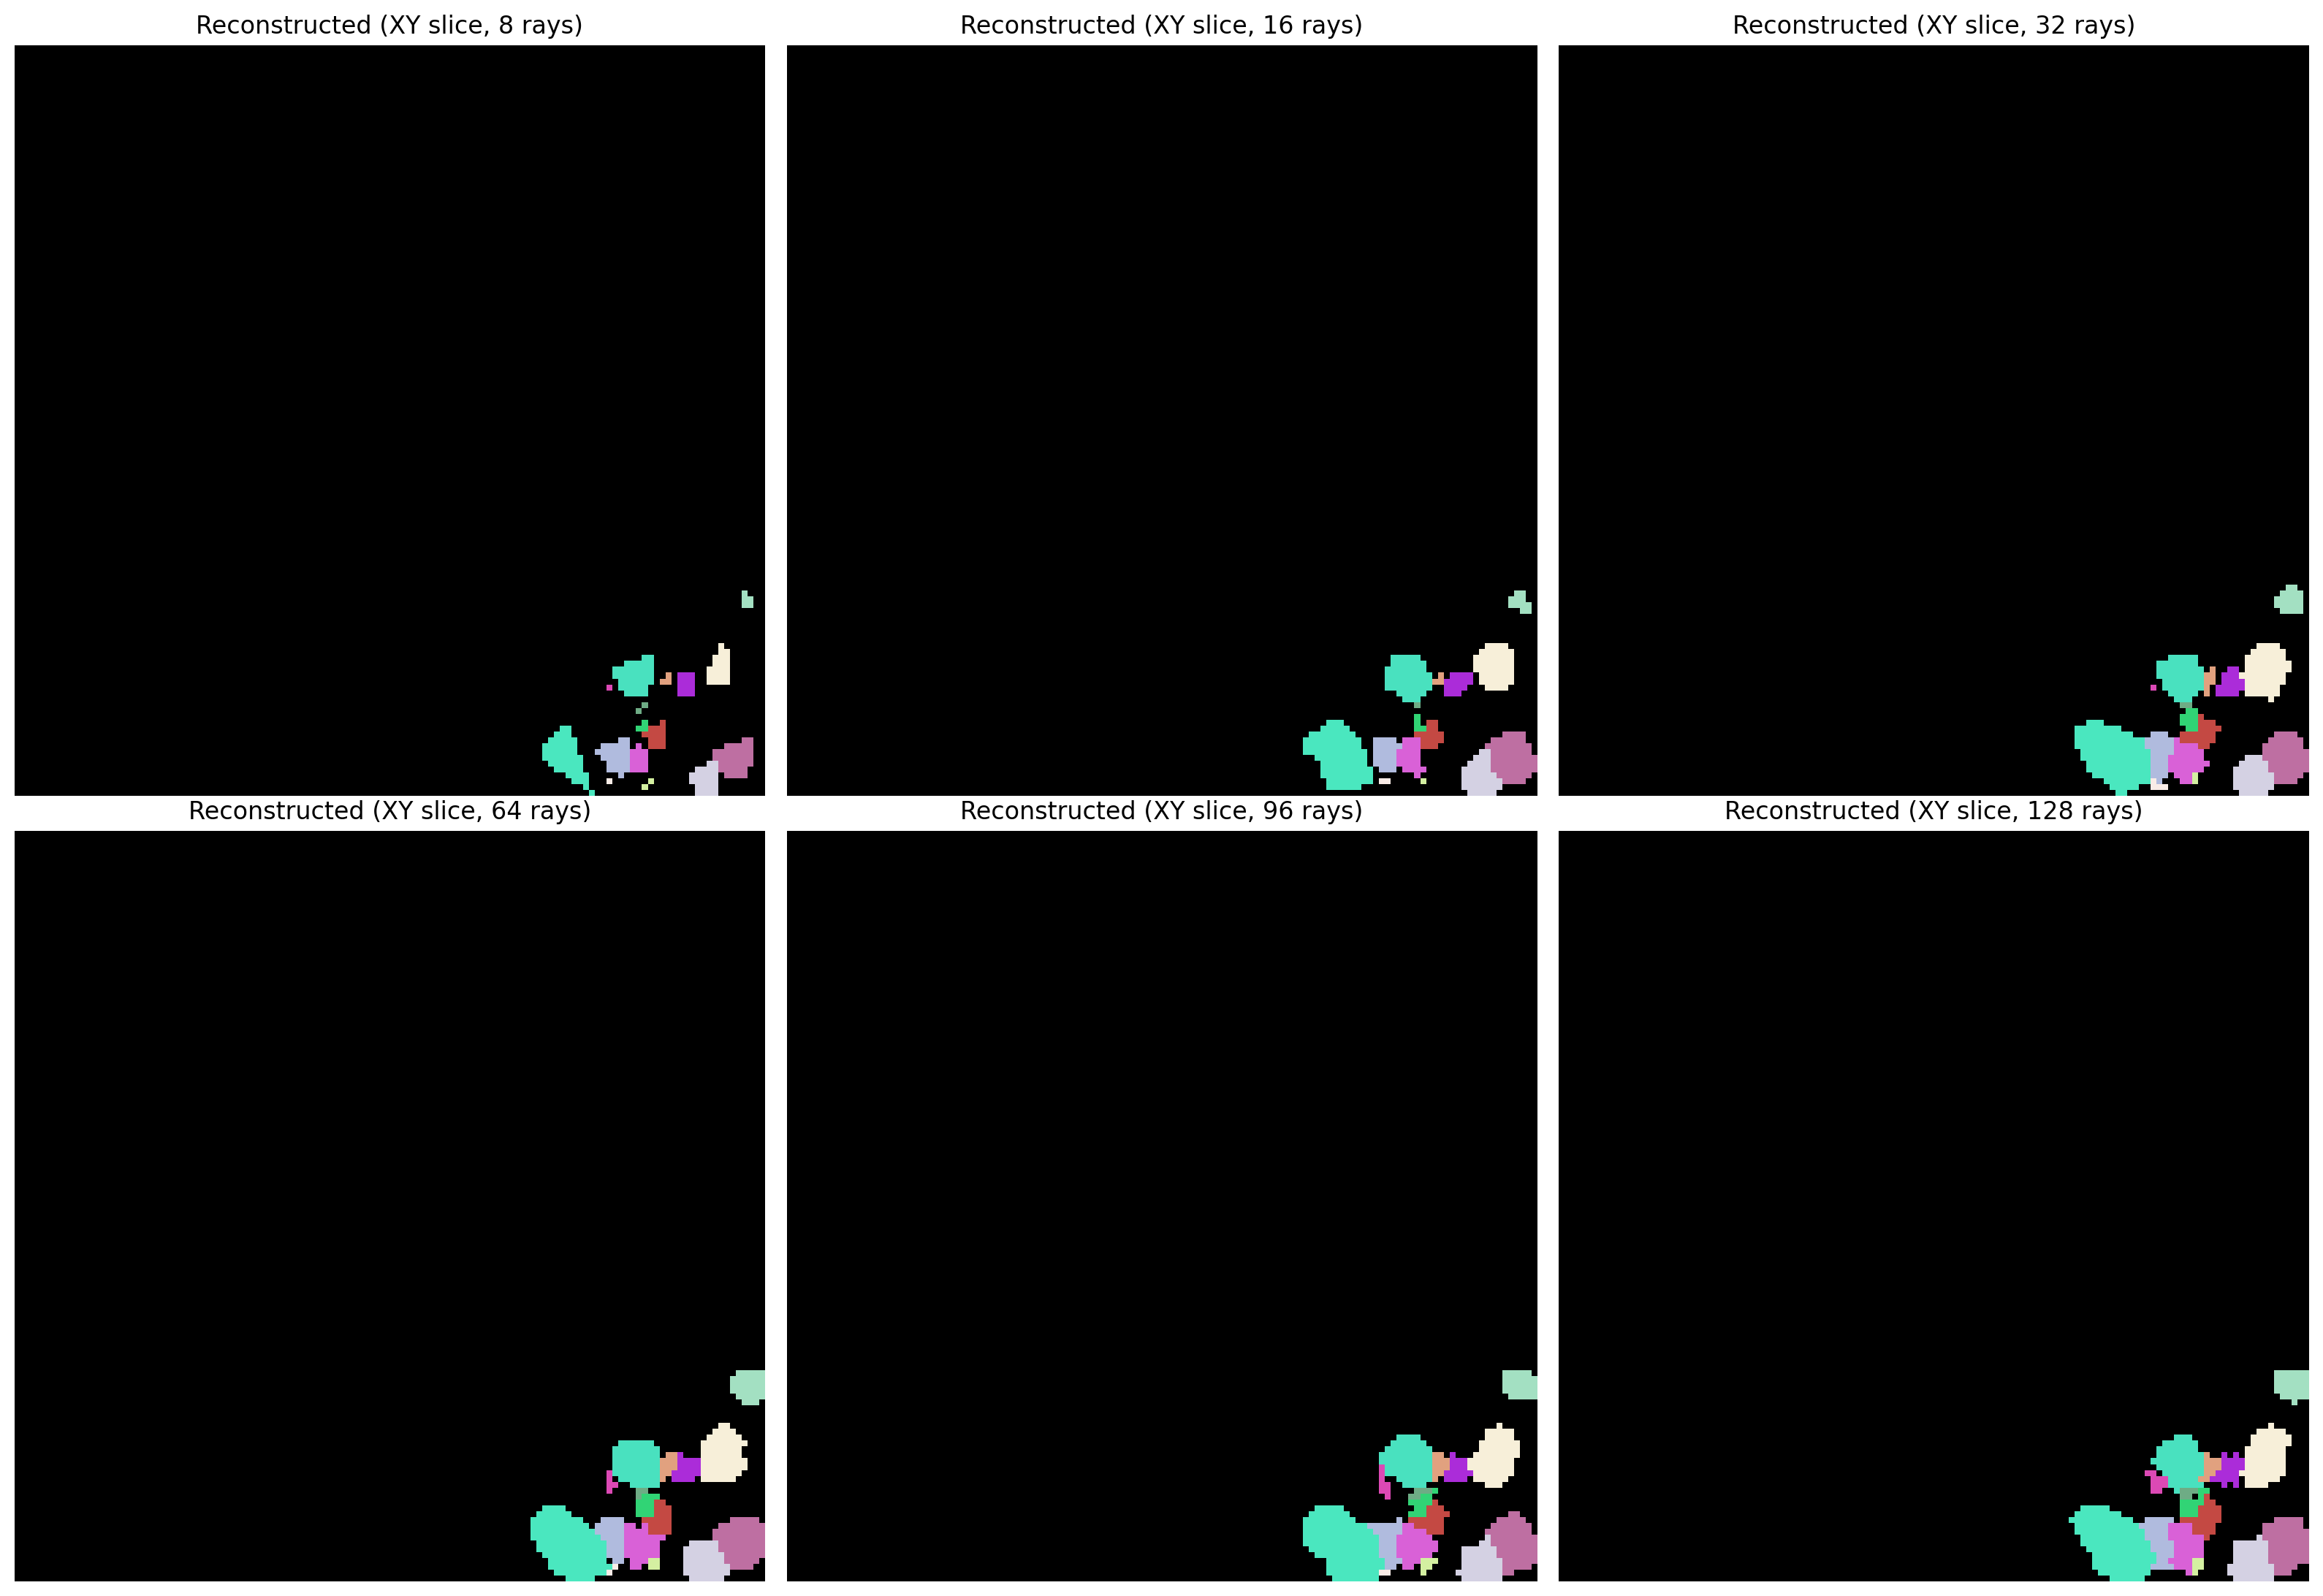

In [28]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();